<a href="https://colab.research.google.com/github/mk-armah/testgit/blob/master/CIFAR10_dataset_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [ ]:
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914,0.4822,0.4465),(0.2021,0.1994,0.2010)),
                                transforms.RandomHorizontalFlip()])

In [ ]:

train_data = torchvision.datasets.CIFAR10(root = './data',train = True,download= True,transform=transform)
test_data = torchvision.datasets.CIFAR10(root = './data',train = False,download = True,transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_data)

50000

In [ ]:
print("classes >>> ",train_data.classes)

classes >>>  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
idx = np.arange(50000)
np.random.shuffle(idx)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle = False,sampler=torch.utils.data.SubsetRandomSampler(idx[0:40000]))
val_loader = torch.utils.data.DataLoader(train_data,batch_size = 64,shuffle =False,sampler = torch.utils.data.SubsetRandomSampler(idx[40000:50000]))
test_loader = torch.utils.data.DataLoader(test_data,batch_size = 64,shuffle = True)

In [ ]:
print('shape of training data ::: ',train_data.data.shape)
print("shape of testing data ::: ",test_data.data.shape)

shape of training data :::  (50000, 32, 32, 3)
shape of testing data :::  (10000, 32, 32, 3)


100%|██████████| 12/12 [00:00<00:00, 54.47it/s]


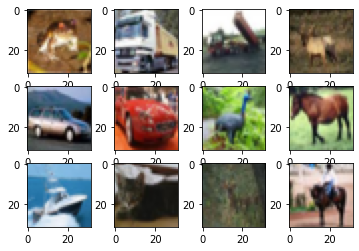

In [ ]:
for i in tqdm(range(12)):
  plt.subplot(3,4,i+1)
  plt.imshow(train_loader.dataset.data[i])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

print(torch.__version__)
print(torch.version.cuda)

cuda
0
Tesla K80
1.10.0+cu111
11.1


In [ ]:
class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet,self).__init__()
    self.conv2d = nn.Sequential(torch.nn.Conv2d(in_channels=3,out_channels = 8,kernel_size=3,stride = 1,padding = 1),
                                nn.ReLU(inplace = True),
                                torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
                                torch.nn.BatchNorm2d(8),
                                torch.nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5,stride = 1,padding = 2),
                                nn.ReLU(inplace = True),
                                torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
                                torch.nn.BatchNorm2d(16),
                                torch.nn.Conv2d(in_channels=16,out_channels = 32,kernel_size = 5,stride = 1,padding = 1),
                                torch.nn.ReLU(inplace = True),
                                torch.nn.MaxPool2d(kernel_size = 2,stride = 1))
    
    self.Flatten = nn.Flatten()

    self.fc_layers = nn.Sequential(torch.nn.Dropout2d(p=0.20),
                                  nn.Linear(800,500),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(500,700),
                                  nn.Dropout2d(p = 0.30),
                                  nn.ReLU(inplace = True),
                                  nn.Linear(700,300),
                                  nn.ReLU(inplace = True),
                                  nn.Linear(300,150),
                                  nn.Dropout(p = 0.20),
                                  nn.ReLU(inplace = True),
                                  nn.Linear(150,10))
    
  def forward(self,image):
    image = self.conv2d(image)
    image = self.Flatten(image)
    image = self.fc_layers(image)

    return image

    

In [ ]:
# def size_calculator(i,f,p,s):
#   return ((((i-f)+2*p)/s)+1)

# size_calculator(8,5,1,1)

32*3*3

288

In [ ]:
model = CustomNet().to(device)
loss_fn =nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),lr = 0.1)

In [ ]:
def training(model,dataloader,optimizer,loss_fn):
  model.train()
  num_batches = len(dataloader)
  data_size = len(dataloader.dataset)

  training_accuracy,training_loss = 0,0
  for batch,(images,labels) in enumerate(dataloader):
    images,labels = images.to(device),labels.to(device)
    
    #forward 
    y_pred = model(images)

    #compute the loss
    loss = loss_fn(y_pred,labels)

    #empty the gradients by setting them to zero
    optimizer.zero_grad()

    #back propagation
    loss.backward()

    #update the weights
    optimizer.step()

    acc = (y_pred.argmax(1)==labels).sum().type(torch.FloatTensor).item()
    training_accuracy+=acc

  training_accuracy/= data_size 
  print("Training Accuracy >>> ",training_accuracy)

In [ ]:
def testing_validation(model,dataloader,loss_fn):
  data_size = len(dataloader.dataset)
  num_batches = len(dataloader)
  testing_loss,testing_accuracy = 0,0
  with torch.no_grad():
    for images,labels in dataloader:
      images,labels = images.to(device),labels.to(device)

      y_pred = model(images)

      loss = loss_fn(y_pred,labels)
      acc = (y_pred.argmax(1)==labels).sum().type(torch.FloatTensor).item()
      
      testing_accuracy += acc
      testing_loss += loss

    testing_accuracy /= data_size
    testing_loss/= num_batches

    print("Testing Accuracy >>> ",testing_accuracy,"  <::::::> ", "Average Loss >>> ", testing_loss.item(),"\n")

In [ ]:
num_epochs = 20

for epochs in tqdm(range(num_epochs)):
  #print("Epoch",epochs+1,"/",num_epochs)
  training(model,train_loader,optimizer,loss_fn)
  testing_validation(model,test_loader,loss_fn)
print("Epochs Completed")

  0%|          | 0/20 [00:00<?, ?it/s]

Training Accuracy >>>  0.65382


  5%|▌         | 1/20 [00:27<08:50, 27.90s/it]

Testing Accuracy >>>  0.7372
Average Loss >>>  0.8274165987968445 

Training Accuracy >>>  0.65706


 10%|█         | 2/20 [00:55<08:22, 27.89s/it]

Testing Accuracy >>>  0.7358
Average Loss >>>  0.8184207081794739 

Training Accuracy >>>  0.66018


 15%|█▌        | 3/20 [01:23<07:52, 27.80s/it]

Testing Accuracy >>>  0.7332
Average Loss >>>  0.8180917501449585 

Training Accuracy >>>  0.66574


 20%|██        | 4/20 [01:51<07:27, 27.97s/it]

Testing Accuracy >>>  0.7339
Average Loss >>>  0.8305050134658813 

Training Accuracy >>>  0.66668


 25%|██▌       | 5/20 [02:19<06:57, 27.86s/it]

Testing Accuracy >>>  0.7236
Average Loss >>>  0.9019883275032043 

Training Accuracy >>>  0.67132


 30%|███       | 6/20 [02:47<06:29, 27.82s/it]

Testing Accuracy >>>  0.7362
Average Loss >>>  0.8715913891792297 

Training Accuracy >>>  0.67558


 35%|███▌      | 7/20 [03:14<06:01, 27.80s/it]

Testing Accuracy >>>  0.7365
Average Loss >>>  0.8358587026596069 

Training Accuracy >>>  0.68002


 40%|████      | 8/20 [03:42<05:33, 27.79s/it]

Testing Accuracy >>>  0.7437
Average Loss >>>  0.8471236824989319 

Training Accuracy >>>  0.68174


 45%|████▌     | 9/20 [04:10<05:05, 27.79s/it]

Testing Accuracy >>>  0.7424
Average Loss >>>  0.8589816689491272 

Training Accuracy >>>  0.68404


 50%|█████     | 10/20 [04:38<04:37, 27.73s/it]

Testing Accuracy >>>  0.7347
Average Loss >>>  0.8579019904136658 

Training Accuracy >>>  0.6868


 55%|█████▌    | 11/20 [05:05<04:09, 27.74s/it]

Testing Accuracy >>>  0.7367
Average Loss >>>  0.892937183380127 

Training Accuracy >>>  0.68918


 60%|██████    | 12/20 [05:33<03:41, 27.74s/it]

Testing Accuracy >>>  0.7398
Average Loss >>>  0.878787100315094 

Training Accuracy >>>  0.6919


 65%|██████▌   | 13/20 [06:01<03:14, 27.73s/it]

Testing Accuracy >>>  0.7356
Average Loss >>>  0.9294229745864868 

Training Accuracy >>>  0.69402


 70%|███████   | 14/20 [06:29<02:46, 27.75s/it]

Testing Accuracy >>>  0.7359
Average Loss >>>  0.9339672923088074 

Training Accuracy >>>  0.69752


 75%|███████▌  | 15/20 [06:56<02:18, 27.70s/it]

Testing Accuracy >>>  0.728
Average Loss >>>  0.944368302822113 

Training Accuracy >>>  0.69936


 80%|████████  | 16/20 [07:24<01:50, 27.69s/it]

Testing Accuracy >>>  0.7396
Average Loss >>>  0.9266746044158936 

Training Accuracy >>>  0.70114


 85%|████████▌ | 17/20 [07:51<01:22, 27.67s/it]

Testing Accuracy >>>  0.7307
Average Loss >>>  0.9566169381141663 

Training Accuracy >>>  0.70434


 90%|█████████ | 18/20 [08:19<00:55, 27.67s/it]

Testing Accuracy >>>  0.7323
Average Loss >>>  0.9445609450340271 

Training Accuracy >>>  0.70744


 95%|█████████▌| 19/20 [08:47<00:27, 27.68s/it]

Testing Accuracy >>>  0.7392
Average Loss >>>  0.9519181251525879 

Training Accuracy >>>  0.70708


100%|██████████| 20/20 [09:14<00:00, 27.74s/it]

Testing Accuracy >>>  0.7358
Average Loss >>>  0.9548050165176392 

Epochs Completed
